In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from mcl import *

In [2]:
class Goal: 
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.16, y + 0.5, s=50, marker=">", label="landmarks", color="red") #旗
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 0.6], color="black") #旗竿

In [3]:
class Puddle:
    def __init__(self, lowerleft, upperright, depth):
        self.lowerleft = lowerleft
        self.upperright = upperright
        self.depth = depth
        
    def draw(self, ax, elems):
        w = self.upperright[0] - self.lowerleft[0]
        h = self.upperright[1] - self.lowerleft[1]
        r = patches.Rectangle(self.lowerleft, w, h, color="blue", alpha=self.depth)
        elems.append(ax.add_patch(r))
        
    def inside(self, x, y): ###puddleinside 
        return self.lowerleft[0] < x < self.upperright[0] and self.lowerleft[1] < y < self.upperright[1]

In [4]:
class PuddleWorld(World):
    def __init__(self, time_span, time_interval):
        super().__init__(time_span, time_interval)
        self.puddles = []
        self.robots = []
        
    def append(self,obj):
        self.objects.append(obj)
        if isinstance(obj, Puddle): self.puddles.append(obj)
        if isinstance(obj, PuddleRobot): self.robots.append(obj)
        
    def puddle_depth(self, pose):
        return sum([p.depth * p.inside(pose[0], pose[1]) for p in self.puddles])
    
    def one_step(self, i, elems, ax):
        super().one_step(i, elems, ax)
        for obj in self.robots:
            obj.puddle_depth = self.puddle_depth(obj.pose)

In [5]:
class PuddleRobot(Robot):
    def __init__(self, pose, agent=None, sensor=None, color="black", \
                           noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1), \
                           expected_stuck_time=1e100, expected_escape_time = 1e-100,\
                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0), \
                           puddle_coef=1.0):  #追加
        super().__init__(pose, agent, sensor, color, noise_per_meter, noise_std, bias_rate_stds, \
                         expected_stuck_time, expected_escape_time, expected_kidnap_time, kidnap_range_x, kidnap_range_y)
        
        self.puddle_depth = 0.0             #水たまりの深さ
        self.puddle_coef = puddle_coef  #水たまりの深刻度を表す定数
        
    def reward_per_sec(self):
        return -1.0 - self.puddle_depth*self.puddle_coef
        
    def draw(self, ax, elems): 
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, 4.0, "reward/sec:" + str(self.reward_per_sec()), fontsize=10))

In [6]:
class PuddleIgnoreAgent(MclAgent):  ###puddleignoreagent
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, goal, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #goal追加
        super().__init__(time_interval, nu, omega, particle_pose, envmap, particle_num, motion_noise_stds)
        
        self.goal = goal
        
    def decision(self, observation=None):
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        self.mcl.observation_update(observation)
        return self.nu, self.omega

<IPython.core.display.Javascript object>


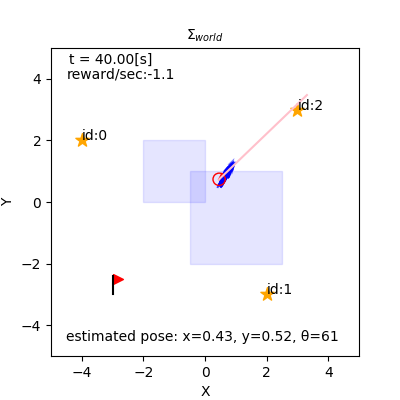

In [7]:
if __name__ == '__main__':
    time_interval = 0.1
    world = PuddleWorld(40, time_interval) 

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ###ゴールの追加###
    world.append(Goal(-3,-3))
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ### ロボットを作る ###
    circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100) 
    r = PuddleRobot(np.array([0,0,0]).T, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0),
              agent=circling, color="red", bias_rate_stds=(0,0)) #ロボットを変更

    world.append(r)
    
    world.draw()